In [10]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 22 10:51:51 2015

@author: Jozef

Import all modules and packages which will be used
"""
%pylab inline

import numpy as np # for Numerical Python
import scipy.special as scs # for Bessel functions (special functions in the Scientific Python package)
from scipy.optimize import brenth # for finding zero of a function
import scipy.odr.odrpack as odrpack #  for Orthogonal Distance Regression Package (ODRPACK 2.1)
import os # for files manipulatios (operating system package)



Populating the interactive namespace from numpy and matplotlib


In [11]:

## define global values of parameters (CGS units) 
a = 1.0 #  thermal diffusivity
L = 1.0# sample thickness
R = 6.35 # sample radius
IRI = 0.0 # irradiated radius inner
IRO = 5.35 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 4.1 # viewed radius outer

# Theoretical values
# my theoretical values used for calculation of 'experimental' data, feel free to change them!
baseline_theor = -5.0
Tmax_theor = 3.0  # Tmax (adiabatic)
td_theor = 1.17 # thermal diffusivity
Biot_theor  = 0.01 # dimensionless parameter m

# define a new vector for them
theors = [baseline_theor, Tmax_theor, td_theor, Biot_theor] 


In [12]:
# define new constants and functions for analytical temperature distribution calculations

# calculate dimensionless radii
IRID = IRI/R
IROD = IRO/R
VRID = VRI/R
VROD = VRO/R

# define Biot numbers for front, rear, radial of a cylindrical shape sample
Bio = [Biot_theor, Biot_theor, Biot_theor*L/R]

def rootsearch(f,a,b,Bio,dx):
    x1 = a; f1 = f(a, Bio)
    x2 = a + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a, b, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a,b,Bio,eps)
        if x1 != None:
            a = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break

# transcendental functions for eigenvalues calculations
def funA(x,Bio): 
    return (x*x-Bio[0]*Bio[1])*np.sin(x) - (Bio[0]+Bio[1])*x*np.cos(x)
    
def funR(x,Bio): 
    return (x*scs.j1(x) - Bio[2]*scs.j0(x))

# eigenvalues - root of the transcendental functions
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200)


def flash1D(t, a): # One dimensional ideal model (an instantaneous heat pulse, no heat losses)
    suma =0.0
    for n in range(1, 50):
        suma = suma + (-1)**n*np.exp(-((n*np.pi)**2*a*t/L**2))
    return (1+2.0*suma)

def flash1DHL(t, a, Bio, gamas): # One dimensional model with heat losses

    Bi1=Bio[0]
    Bi2=Bio[1]

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return suma
 
def flash2DHL(t, a, Bio, gamas, betas): # Two dimensional model with heat losses

    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    g2 = list(np.array(gamas)**2)
    b2 = list(np.array(betas)**2)

    sumaA = 0.0
    for i in range(0, len(gamas)):
       sumaA = sumaA + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)

    sumaR = 0.0
    for i in range(0, len(betas)):
        sumaR = sumaR + 4*(VRID*scs.j1(betas[i]*VRID)
        -VROD*scs.j1(betas[i]*VROD))*(IRID*scs.j1(betas[i]*IRID)
        -IROD*scs.j1(betas[i]*IROD))/((b2[i]+Bi3**2)*scs.j0(betas[i])**2
        *(IROD**2-IRID**2)*(VROD**2-VRID**2))*np.exp(-b2[i]*a*t/R**2)
    
    return sumaA * sumaR

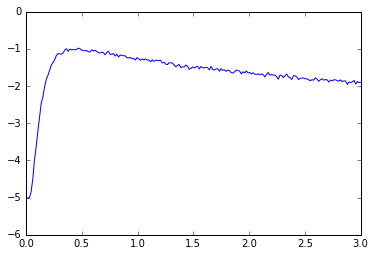

In [13]:
# Simulate 'experimental' data a prepare a layer for plot
from matplotlib import pyplot
N=200 # number of experimental points
time = np.linspace(0.001,3.,N) # define time points
noise = 0.01 # sigma (relative to Tmax) for noise level
temperature=baseline_theor+Tmax_theor*(flash2DHL(time, td_theor, Bio, gamas, betas) # calculate the temperature in time
    + np.random.normal(0,noise,N)) # and add Gaussian noise with sigma = noise
pyplot.plot(time, temperature) # plot Experimental Data

In [14]:
## ODRPACK application

# first delete the file 'filename' if it already exist to make room for a new one, generated by the ODRPACK
filename="results2Dodr.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
def f2DHL(B, x):
    Bio = [B[3], B[3], B[3]*L/R]
    gamas = mroots(funA, Bio, 0.0001, 200) # calculate the first ~ 80 positive roots
    betas = mroots(funR, Bio, 0.0001, 200) 
    return B[0]+B[1]*flash2DHL(x, B[2], Bio, gamas, betas) 
    
flash = odrpack.Model(f2DHL) # our model will use 2D model with heat losses

mydata = odrpack.RealData(time, temperature, sx=0.00001, sy=0.0001) # use already simulated data. sx and sy are uncertainties for time and temperature points, resp.

myodr = odrpack.ODR(mydata, flash, beta0=[-4.,4.5, 1.3, 0.02], ifixb=[1,1,1,1],
                    iprint=6616, rptfile=filename ) # define ODRPACK input parameters - beta0 are initial guess values
                                                    # for the baseline level Beta[0], Tmax Beta[1], the thermal diffusivity Beta[2], and the Biot number Beta[3]
myoutput = myodr.run() # run Forrest (ODRPACK), run
myoutput.pprint() # print a standard simple output

# more detail report from the ODRPACK is in a freshly created text file "results2Dodr.txt"  

Beta: [-5.01971277  3.00842832  1.16931919  0.00951386]
Beta Std Error: [ 0.0167585   0.0125548   0.00734779  0.00050929]
Beta Covariance: [[  3.18583575e-09  -2.24198042e-09  -4.36034315e-10   5.21636549e-11]
 [ -2.24198042e-09   1.78802263e-09   2.20838403e-10  -1.94292815e-11]
 [ -4.36034315e-10   2.20838403e-10   6.12444799e-10  -2.90795345e-11]
 [  5.21636549e-11  -1.94292815e-11  -2.90795345e-11   2.94232428e-12]]
Residual Variance: 88154.9797195
Inverse Condition #: 0.0160371051317
Reason(s) for Halting:
  Sum of squares convergence


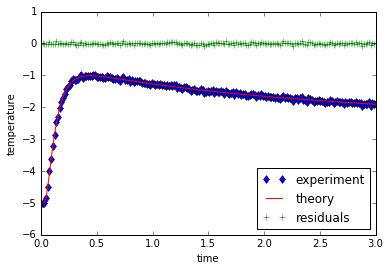

Relative errors [baseline level, Tmax, thermal diffusivity, Biot number] in percent are: 
[ 0.39425534  0.28094406 -0.05818911 -4.86139219]

 
 Histogram of residual values


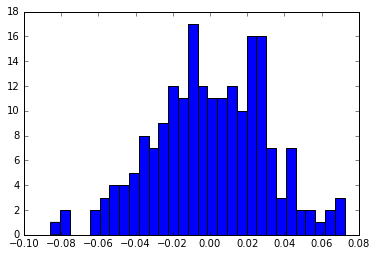

In [17]:
# reconstruct the theoretical curve from the calculated values 

B = myoutput.beta # final results of calculated optimal parameters
Bio=[B[3],B[3],B[3]*L/R]
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200) 
theory = B[0]+B[1]*flash2DHL(time, B[2], Bio, gamas, betas) 
pyplot.plot(time, temperature, 'bd', label="experiment")
pyplot.plot(time, theory,'r', label="theory")
residuals = temperature - theory
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time")
pyplot.ylabel("temperature")
pyplot.legend(loc=4)
pyplot.show()

pyplot.hist(residuals, 30) # plot histogram of residuals

# calculate relative errors
errors = (B-theors)/theors*100 
print 'Relative errors [baseline level, Tmax, thermal diffusivity, Biot number] in percent are: \n',errors
print "\n \n Histogram of residual values"
